In [2]:
from sae_lens import HookedSAETransformer, SAE, SAEConfig
from gemma_utils import get_gemma_2_config, gemma_2_sae_loader


In [79]:
import numpy as np
import torch
import einops
import re
from jaxtyping import Int, Float
from typing import List, Optional, Any
from torch import Tensor
import json
import os
from torch.utils.data import Dataset, DataLoader
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [82]:
np.random.seed(0)
random.seed(0)
torch.random.manual_seed(0)

### Get the model

In [7]:
model = HookedSAETransformer.from_pretrained("google/gemma-2-2b-it")

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


## Get the dataset

In [83]:
from datasets import load_dataset

ds = load_dataset("santhoshmlops/Skai_Gemma_Instruct_ChatTemplate",split = "train")
text = ds[:300]['text']
tokenized_ds = model.tokenizer(text, return_tensors = "pt", padding = True)
pairs_length = tokenized_ds['attention_mask'].sum(dim = -1).numpy()
indices = torch.where(torch.tensor(np.logical_and(pairs_length>100, pairs_length<500)))
text_array = np.array(text)[indices]
samp_ind = torch.randint(0,len(text_array), (1,100))
final_text = text_array[samp_ind].tolist()[0]
tokens = model.tokenizer(final_text, return_tensors = "pt", padding = True)


<Axes: ylabel='Count'>

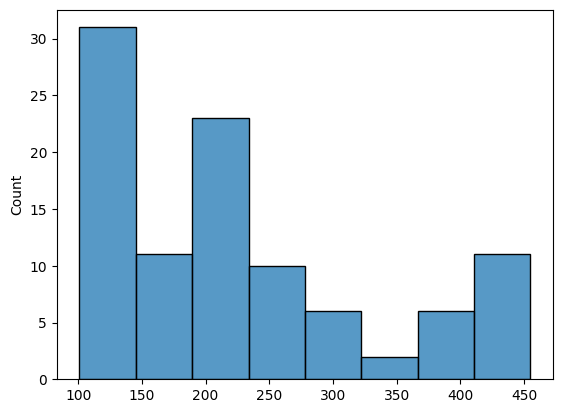

In [84]:
sns.histplot(tokens['attention_mask'].sum(dim = -1).numpy())

In [100]:
len(torch.where(tokens['input_ids']==106)[0])# checks out 2 turns for each datapoint

200

In [101]:
starts_model_turn_pos = torch.stack([torch.where(tok == 106)[0][-1] for tok in tokens["input_ids"]])# get the second turn

<Axes: ylabel='Count'>

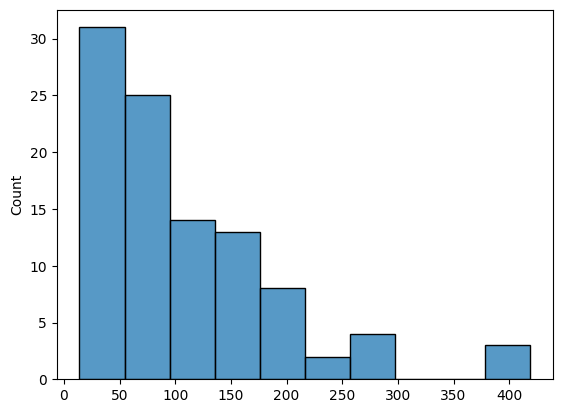

In [104]:
sns.histplot(tokens['attention_mask'].sum(dim = -1)-starts_model_turn_pos)